# Pre-MODFLOW6 modeling with FloPy (Steady State)

In this notebook, we will introduce the modularization concepts of MODFLOW (Pre-MODFLOW6) and demonstrate how the FloPy interface can be used to create, run, and visualize results from a basic model. In the process, we'll discuss common problems that can be introduced when designing models and how to avoid them through both visualization and error-checking routines in FloPy.

As described earlier, MODFLOW 6 represents a major paradigm shift in model creation, input / output file structure, and model execution. Current development efforts in FloPy are also more highly focused on interaction with MODFLOW 6 models, and you will notice differencese between the way FloPy interacts with MODFLOW 6 models vs. Pre-MODFLOW6 models. You will probably find that you enjoy working with FloPy more when working on MODFLOW 6 models. And when developing new models, the capabilities of MODFLOW 6 are much more flexible than prior MODFLOW versions. 

So why the heck should we learn about pre-MODFLOW 6 modeling and FloPy's interfaces for these?!? **Because the majority of existing MODFLOW models (and therefore many you will encounter) are written in MODFLOW-2005 / MODFLOW-NWT or prior versions.** Therefore, understanding the structure of these models and their use is crucial to working with most existing models. Being able to use FloPy on pre-MODFLOW6 models also allows you to "upgrade" these models to newer MODFLOW versions.


## Learning Objectives

After you have read and run this notebook, you should be able to:
* Describe the modular structure used in MODFLOW-2005 / MODFLOW-NWT and prior versions (i.e., Pre-MODFLOW6), and the necessary inputs to create a well-defined steady-state model.
* Apply FloPy utilities to visualize, debug, and verify Pre-MODFLOW6 model inputs.
* Create a complete set of input files needed for a Pre-MODFLOW6 model to run successfully.
* Use data extraction and post-processing routines to visualize model results and apply "hydrosense"

## Initial Setup

For this notebook, we will import flopy and also define shortcuts to the `flopy.discretization` module as `fpd`.

To simplify plotting later in the notebook, we also define a function `combined_gridplot` which produces both a cross-section and map view of the model area, similar to what is viewable in Groundwater Vistas. The function returns handles to the figure object, subplot axes objects, and graphics objects so that you can further modify the plots with later commands. As you go through the class, you may consider using `combined_gridplot` as a template to build more sophisticated visualizations of your model grid.

In [1]:
import flopy
import flopy.utils as fpu
import flopy.discretization as fpd

#TODO: I'd prefer not to do this. Why doesn't explicit work?
from flopy.utils.triangle import Triangle
from flopy.utils.voronoi import VoronoiGrid
from flopy.utils.gridgen import Gridgen

import numpy as np
import matplotlib.pyplot as plt
import os

# Here is a starter function that you may modify in order to build your own useful utilities for working
# with FloPy
def combined_gridplot(modelgrid_in,cross_type="row", cross_num=0,vert_exag=1):
    fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(5,5),height_ratios=[0.2,1])

    try:
        axs[0].set_aspect(vert_exag)
        pcr = flopy.plot.PlotCrossSection(modelgrid=modelgrid_in, ax=axs[0], line={cross_type: cross_num}, geographic_coords=True)
        pcr.plot_grid(lw=0.5)
        if cross_type=="row":
            axs[0].set_xlabel('x')
        elif cross_type=="column":
            axs[0].set_xlabel('y')
        axs[0].set_ylabel('z')
        axs[0].set_title(f'Cross-section through {cross_type} {cross_num}, Vertical Exag = {vert_exag}')
    except:
        print('Cross-section could not be generated. Check inputs')
        pcr = None
    
    axs[1].set_aspect(1)
    pmv = flopy.plot.PlotMapView(modelgrid=modelgrid_in, ax=axs[1])
    pmv.plot_grid(lw=0.5)
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    axs[1].set_title(modelgrid_in)
    return fig, axs, [pcr, pmv]


# Building the model inputs with FloPy 

## Step 1: Creating the model object

When you first create the `model` object, you supply FloPy with basic information including where you want the model files stored, where the MODFLOW executables can be found and, crucially, **what version of MODFLOW** you want this model to be. FloPy uses this information to tailor its model creation routines and error checking so that it is consistent with the needs of the given MODFLOW version.

In [2]:
#We will put the model files in a subdirectory under our "models" directory.
#The model_nm variable sets the filenames for all package inputs
model_dir = os.path.join('.','models','mf2005init')
model_nm = "mf2005init"
#We also tell FloPy where to find the model executable, and what 
#version of MODFLOW we want to use.
bin_dir = os.path.join('.','bin')
mf_exec = 'mf2005'

#STEP 1: CREATE THE MODEL OBJECT
model = flopy.modflow.Modflow(
    modelname=model_nm,
    model_ws=model_dir,
    exe_name=os.path.join(bin_dir,mf_exec),
    version=mf_exec,
)

## Step 2: Building the grid

In pre-MODFLOW6 models, information for the following two packages are **required of all models**:
* The **DIS (discretization) package** describes model spatial discretization and (if used) metadata that places the model within world coordinates. The DIS package also supplies the time discretization information. 
* The **BAS (basic) package** describes which model cells are active.

Using `flopy.modflow.ModflowDis` and `flopy.modflow.ModflowBas`, you could directly supply the inputs required by these packages, but **this is strongly discouraged!**. 

Instead, FloPy's discretization module -- which we saw in the last notebook -- provides a consistent way to create and store information about Structured and Vertex-based Unstructured grids. **It is always a good idea** to therefore use `flopy.discretization` first to create a separate modelgrid object. With this approach, we can take advantage of unified plotting and error checking functionality before translating into what the DIS and BAS packages need.

One example of the benefits of a `modelgrid` created by FloPy is that if you forget to supply an optional input (e.g., the `angrot` angle of rotation value), it will automatically be populated with a default value.

When initializing each of the MODFLOW packages using FloPy, it is common to use this syntax:
`dis = flopy.modflow.ModflowDis(model,...)`
Please note that this accomplishes two things:
1. It actually edits the `model` object to contain the new information for this package, and
2. It creates a new object `dis` that only contains the subset of information in the DIS package

Strictly speaking, objects like `dis` are unnecessary and can be deleted as soon as they are created, but they provide useful tools for error checking, as demonstrated below.

Grid Valid   :  True
Grid Complete:  True


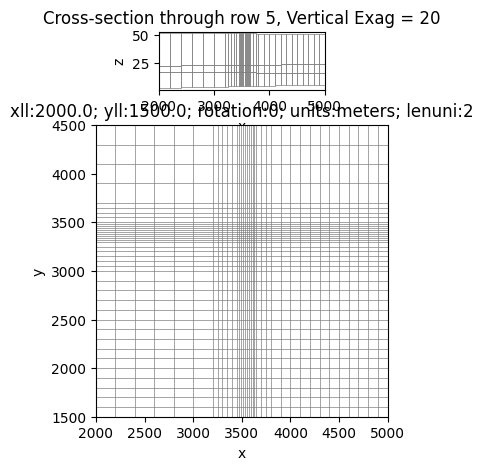

In [3]:
#STEP 2A: CREATE THE MODELGRID OBJECT

#User definition of the grid boundaries and setup, from earlier.
xb = np.concatenate((np.arange(2000,3200,200), 
                    np.arange(3200,3450,50), 
                    np.arange(3450,3650,20), 
                    np.arange(3650,3800,50),
                    np.arange(3800,5000+.1,100)),0)
yb = np.concatenate((np.arange(1500,3000,100),
                     np.arange(3000,3300,50),
                     np.arange(3300,3500,20),
                     np.arange(3500,3700,50),
                     np.arange(3700,4500+.1,200)),0)[::-1]
xm = (xb[0:(len(xb)-1)] + xb[1:(len(xb))])/2
ym = (yb[0:(len(yb)-1)] + yb[1:(len(yb))])/2
xmg, ymg = np.meshgrid(xm,ym)

#Define units for the numbers above
units = 'm'

#Define some sloping planes based on functions evaluated at cell center coordinates
top = 50 - 0.0005*(xmg - 2000) + 0.001*(ymg - 1500)
botmlay0 = 20 + 0.0005*(xmg - 2000) + 0.001*(ymg - 1500)
botmlay1 = 19 - 0.0005*(xmg - 2000) - 0.001*(ymg - 1500)
botmlay2 = 0 + 0.001*(xmg - 2000) + 0.001*(ymg - 1500)

#Calculate the inputs, in MODFLOW / FloPy-speak
#find lower-left x coordinate, and calculate step size, left to right
xoff = xb[0]
delr = np.diff(xb)
ncol = delr.shape[0]
#find lower-left coordinate, and calculate step size from top to bottom
yoff = yb[-1]
delc = -np.diff(yb)
nrow = delc.shape[0]

botm = np.stack((botmlay0,botmlay1, botmlay2),0)
nlay = botm.shape[0]
ibound = np.ones((nlay, nrow, ncol))

modelgrid = fpd.StructuredGrid(
    delc=delc,
    delr=delr,
    top=top,
    botm=botm,
    idomain=ibound,
    xoff=xoff,
    yoff=yoff,
    lenuni=units,
    angrot=0,
)

print('Grid Valid   : ',modelgrid.is_valid)
print('Grid Complete: ',modelgrid.is_complete)

#Plot using our built-in function
fig, axs, plots = combined_gridplot(modelgrid,cross_type="row",cross_num=5,vert_exag=20)

In [4]:
#STEP 2B: Populate the required DIS package and BAS based on the modelgrid object

#Note: This code does TWO things:
#1. It adds the new information to the model object
#2. It creates a new object, dis, which only contains the discretization information
dis = flopy.modflow.ModflowDis(
    model,
    nlay=modelgrid.nlay,
    nrow=modelgrid.nrow,
    ncol=modelgrid.ncol,
    delr=modelgrid.delr,
    delc=modelgrid.delc,
    top=modelgrid.top,
    botm=modelgrid.botm,
    lenuni=modelgrid.lenuni,
    xul=modelgrid.xyzextent[0],
    yul=modelgrid.xyzextent[3],
    rotation=modelgrid.angrot,
)
#You can either put "dis" in the trash, or you can use it to inspect this one aspect
#of the model.
#Examples commands: These can be used with all package objects
#dis.plot()
#dis.check()
#print(dis.data_list)

bas = flopy.modflow.ModflowBas(model, ibound=modelgrid.idomain, strt=50)


## Step 3: Defining hydraulic properties for the aquifer

All pre-MODFLOW6 models require that **one "Flow Package"** is chosen by the user specified for the model. The term "Flow Package" is a bit of a misnomer, as the key purpose of this package is to specify the hydraulic properties of the aquifer that affect flow. If I had my druthers, these would have been named "Hydraulic Property Packages". Flow packages available include:
* LPF (Layer-Property Flow)
* HUF (Hydrogeologic Unit Flow)
* BCF (Block-Centered Flow)

By far, **the most commonly used package is LPF**, and we will use this flow package consistently when talking about pre-MODFLOW6 models. However, you may encounter an old model that uses one of the other flow packages. 

Properties that are supplied within flow packages include:
* Hydraulic conductivity $K [L/T]$, and associated anisotropy information
* Specific storage coefficients $S_s [L^{-1}]$
* Specific yield $S_y [-]$

FloPy will generally make a good guess at what you mean when you supply inputs for a flow package. If you supply one value, it will assume that the model is homogeneous. If you supply one value per layer, it will figure out that you are specifying values from top to bottom. And, if you do not supply a required input, it will supply a reasonable default value (e.g., $S_s = 10^{-5}$).

At early stages of developing a model, though, it is good practice to **use FloPy's built-in plotting routines for each package** to ensure that inputs are reasonable.

In [5]:
lpf = flopy.modflow.ModflowLpf(
    model,
    hk = [100, 1, 5],
    vka = [50, 0.1, 0.5],
    )
#Use the below to verify that "interpreted" / default inputs are OK
#lpf.plot()
#lpf.check()

## Step 4: Defining stress package inputs

Stress packages are used to define any "hydraulic stress" on the aquifer that influences how groundwater moves. If it might act as a source of water to an aquifer, pull water out of an aquifer, or move water from one place to another within an aquifer, it's a stress. 

The least-complex stress packages to use are:
* CHD (Constant Head) Package
* FHB (Flow and Head Boundary) Package
* GHB (General Head Boundary) Package
* RCH (Recharge) Package
* WEL (Well) Package
* DRN (Drain) Package
* RIV (River) Package

**Each stress package has its own format and type of inputs**, and figuring out what each of the inputs mean (and how the model wants them supplied) is one of the steeper learning curves for MODFLOW. For example, since recharge tends to occur everywhere over an aquifer, the RCH package uses inputs that are the shape of the map-view model grid - an array with size `nrow` by `ncol`. In contrast, wells are usually closer to "points" in space, and so the WEL package wants to know about the specific grid cell where a well is located and the pumping rate, i.e. 3 values per well. Inputs will also get more complex for transient models, as they are specified per "stress period" in the model. 

Like with the flow package, FloPy will often choose reasonable default values if you don't specify all inputs to a stress package.
**Using Shift-tab within each FloPy definition is a good way to learn about the inputs for each stress package, and what defaults will be applied**.

In this code example, we demonstrate an over-simplified case where the grid-based location (row / column) of a well is specified, and other stresses are nicely oriented on the model grid (e.g., the river is exactly one column of the model). A better approach is to **develop a database of model stresses that are grid-independent**, and to then pull them onto the model grid. However, this requires further background in GIS and other utilities and so we'll reserve that for a future notebook.

In [6]:
riv_spd = {0: [[0, i, (modelgrid.ncol-1), 49.5, modelgrid.delc[i]*5, 49] for i in range(modelgrid.nrow)]}
#Note - the below will create a non-physical solution unless a regular grid is used, 
#since the conductance should depend on length x width
#riv_spd = {0: [[0, i, (modelgrid.ncol-1), 49.5, 40, 49] for i in range(modelgrid.nrow)]}

riv = flopy.modflow.ModflowRiv(
    model,stress_period_data=riv_spd
)

rch = flopy.modflow.ModflowRch(
    model,
    rech=0.001)

wel = flopy.modflow.ModflowWel(model,stress_period_data={0: [2, 15, 15, -50]})

## Step 5: Define Numerical and Computational Inputs

Finally, a solver package must be specified which determines how MODFLOW will approach the matrix-vector system of equations that are generated, and output control is used to specify how and where model outputs will be generated.

The user can choose **one solver package**
* DE4 (Direct) Solver
* PCG (Preconditioned conjugate gradient) Solver
* PCGN (Preconditioned conjugate gradient with Improved Nonlinear Control) Solver
* SIP (Strongly Implicit Procedure) Solver
* SOR (Slice Successive Over-Relaxation) Solver
* NWT (Newton-Raphson) Solver (for MODFLOW-NWT only)

Currently, **the most commonly-used solvers for pre-MODFLOW6 models are the PCG and NWT solvers**.

Experimenting with different solvers is, in general, a good practice as the results of your model should not be dependent on the solver used. **If one solver gives a different result than another, you should investigate why**.

In [18]:
pcg = flopy.modflow.ModflowPcg(model)
oc = flopy.modflow.ModflowOc(model)

## Step 6: Write the input files and run MODFLOW

This is the place where all of your hard work has paid off. If you have carefully specified your inputs and used the available debugging / plotting tools, your model should run successfully with two lines of code!

If `success = True`, you are "done".

If (when) your model doesn't run successfully, remember the following approaches:
* Carefully investigate each of the package inputs using the package objects' `.plot()` and `.check()` routines
* Review the `.list` file that is output when MODFLOW runs.

In [19]:
model.write_input()
success, buff = model.run_model(silent=True, report=True)

## Step 7-$\infty$: Processing your results to and changing your model to make it "less wrong"

Even if your model does run, **be skeptical - there is no replacement for hydrosense**. You should have a reasonable expectation of what your results will look like, and whether the output passes the "sniff test".

Remember the old mantra: **all models are wrong** (at least in some way). The job of the good modeler is to know how to test a model well and understand what parts of the model are trustworthy vs. where simplifications or unjustified assumptions have a significant impact on results.

There are many, many ways to stress-test and improve your model. A non-exhaustive list:
* Ensure that your model mass balance is reasonable. Mass should not be created or destroyed.
* Make sure that your model isn't dependent on artificial computational definitions *Example: You get a totally different result when implementing a different solver, or changing solution tolerances, or changing your stress periods*
* Make sure you haven't set (known) values incorrectly. *Example: $S_y = 2$*
* Consider how strongly your model results are impacted by set (uncertain) values. *Example: What if you're wrong about riverbed conductance values?*
* Consider whether unmodeled processes may be important to your results. *Example: How much aquifer compaction might affect these results? What about variable density of water?*

In [20]:
import flopy.utils.binaryfile as bf
headobj = bf.HeadFile(os.path.join(model_dir,f"{model_nm}.hds"))
times = headobj.get_times()
head = headobj.get_data(totim=times[-1])

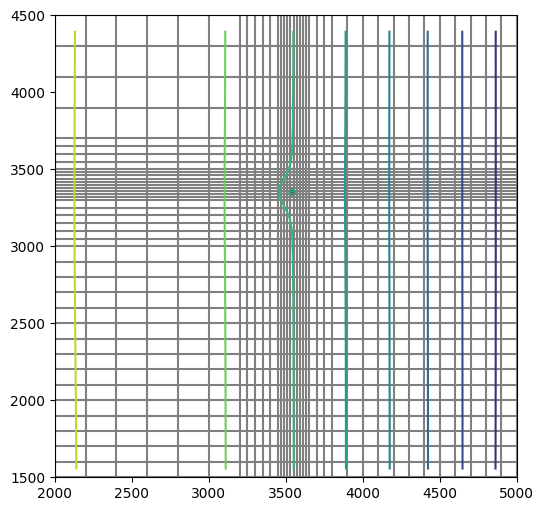

In [21]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(1, 1, 1, aspect="equal")
modelmap = flopy.plot.PlotMapView(model=model,layer=2,ax=ax1)
modelmap.plot_ibound()
modelmap.plot_grid()
modelmap.plot_bc(name="RIV")
modelmap.plot_bc(name="WEL")

modelmap.contour_array(head)

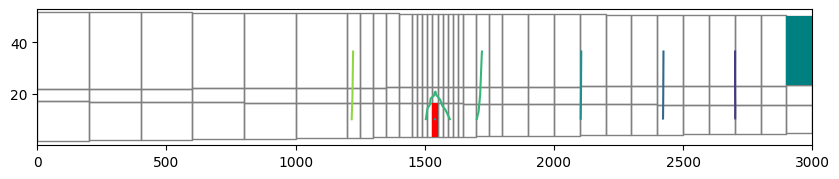

In [22]:
fig = plt.figure(figsize=(10, 10))
ax2 = fig.add_subplot(1, 1, 1, aspect=10)
modelcr = flopy.plot.PlotCrossSection(model=model,line={"row":15},ax=ax2)
modelcr.plot_ibound()
modelcr.plot_grid()
modelcr.plot_bc(name="RIV")
modelcr.plot_bc(name="WEL")
modelcr.contour_array(head)
